In [1]:
#default_exp opts

In [2]:
#export
from collections import defaultdict

import torch
from torch.optim.optimizer import Optimizer, required
import itertools as it
import math
import torch
from torch.optim.lr_scheduler import _LRScheduler

from collections import defaultdict
from itertools import chain
import warnings

warnings.filterwarnings('ignore')

In [3]:
#export
# Lookahead implementation from https://github.com/lonePatient/lookahead_pytorch/blob/master/optimizer.py
class Lookahead(Optimizer):
    '''
    PyTorch implementation of the lookahead wrapper.
    Lookahead Optimizer: https://arxiv.org/abs/1907.08610
    '''
    def __init__(self, optimizer, alpha=0.5, k=6, pullback_momentum="none"):
        '''
        :param optimizer:inner optimizer
        :param k (int): number of lookahead steps
        :param alpha(float): linear interpolation factor. 1.0 recovers the inner optimizer.
        :param pullback_momentum (str): change to inner optimizer momentum on interpolation update
        '''
        if not 0.0 <= alpha <= 1.0:
            raise ValueError(f'Invalid slow update rate: {alpha}')
        if not 1 <= k:
            raise ValueError(f'Invalid lookahead steps: {k}')
        self.optimizer = optimizer
        self.param_groups = self.optimizer.param_groups
        self.alpha = alpha
        self.k = k
        self.step_counter = 0
        assert pullback_momentum in ["reset", "pullback", "none"]
        self.pullback_momentum = pullback_momentum
        self.state = defaultdict(dict)

        # Cache the current optimizer parameters
        for group in self.optimizer.param_groups:
            for p in group['params']:
                param_state = self.state[p]
                param_state['cached_params'] = torch.zeros_like(p.data)
                param_state['cached_params'].copy_(p.data)

    def __getstate__(self):
        return {
            'state': self.state,
            'optimizer': self.optimizer,
            'alpha': self.alpha,
            'step_counter': self.step_counter,
            'k':self.k,
            'pullback_momentum': self.pullback_momentum
        }

    def zero_grad(self):
        self.optimizer.zero_grad()

    def state_dict(self):
        return self.optimizer.state_dict()

    def load_state_dict(self, state_dict):
        self.optimizer.load_state_dict(state_dict)

    def _backup_and_load_cache(self):
        """Useful for performing evaluation on the slow weights (which typically generalize better)
        """
        for group in self.optimizer.param_groups:
            for p in group['params']:
                param_state = self.state[p]
                param_state['backup_params'] = torch.zeros_like(p.data)
                param_state['backup_params'].copy_(p.data)
                p.data.copy_(param_state['cached_params'])

    def _clear_and_load_backup(self):
        for group in self.optimizer.param_groups:
            for p in group['params']:
                param_state = self.state[p]
                p.data.copy_(param_state['backup_params'])
                del param_state['backup_params']

    def step(self, closure=None):
        """Performs a single Lookahead optimization step.
        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = self.optimizer.step(closure)
        self.step_counter += 1

        if self.step_counter >= self.k:
            self.step_counter = 0
            # Lookahead and cache the current optimizer parameters
            for group in self.optimizer.param_groups:
                for p in group['params']:
                    param_state = self.state[p]
                    p.data.mul_(self.alpha).add_(1.0 - self.alpha, param_state['cached_params'])  # crucial line
                    param_state['cached_params'].copy_(p.data)
                    if self.pullback_momentum == "pullback":
                        internal_momentum = self.optimizer.state[p]["momentum_buffer"]
                        self.optimizer.state[p]["momentum_buffer"] = internal_momentum.mul_(self.alpha).add_(
                            1.0 - self.alpha, param_state["cached_mom"])
                        param_state["cached_mom"] = self.optimizer.state[p]["momentum_buffer"]
                    elif self.pullback_momentum == "reset":
                        self.optimizer.state[p]["momentum_buffer"] = torch.zeros_like(p.data)

        return loss

In [23]:
#export
class RAdam(Optimizer):

    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-5, weight_decay=0.01, decouple_wd=True):
        defaults = dict(lr=lr, betas=betas, eps=eps, weight_decay=weight_decay)
        self.buffer = [[None, None, None] for ind in range(10)]
        self.decouple_wd = decouple_wd
        super(RAdam, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(RAdam, self).__setstate__(state)

    def step(self, closure=None):

        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:

            for p in group['params']:
                if p.grad is None:
                    continue
                
                # Perform stepweight decay
                if self.decouple_wd:
                    p.data.mul_(1 - group['lr'] * group['weight_decay'])
                
                grad = p.grad.data.float()
                if grad.is_sparse:
                    raise RuntimeError('RAdam does not support sparse gradients')

                p_data_fp32 = p.data.float()

                state = self.state[p]

                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p_data_fp32)
                    state['exp_avg_sq'] = torch.zeros_like(p_data_fp32)
                else:
                    state['exp_avg'] = state['exp_avg'].type_as(p_data_fp32)
                    state['exp_avg_sq'] = state['exp_avg_sq'].type_as(p_data_fp32)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']

                exp_avg_sq.mul_(beta2).addcmul_(grad, grad, value = 1 - beta2)
                exp_avg.mul_(beta1).add_(grad, alpha=1 - beta1)

                state['step'] += 1
                buffered = self.buffer[int(state['step'] % 10)]
                if state['step'] == buffered[0]:
                    N_sma, step_size = buffered[1], buffered[2]
                else:
                    buffered[0] = state['step']
                    beta2_t = beta2 ** state['step']
                    N_sma_max = 2 / (1 - beta2) - 1
                    N_sma = N_sma_max - 2 * state['step'] * beta2_t / (1 - beta2_t)
                    buffered[1] = N_sma

                    # more conservative since it's an approximated value
                    if N_sma >= 5:
                        step_size = math.sqrt((1 - beta2_t) * (N_sma - 4) / (N_sma_max - 4) * (N_sma - 2) / N_sma * N_sma_max / (N_sma_max - 2)) / (1 - beta1 ** state['step'])
                    else:
                        step_size = 1.0 / (1 - beta1 ** state['step'])
                    buffered[2] = step_size
                
                if not self.decouple_wd:
                    if group['weight_decay'] != 0:
                        p_data_fp32.add_(-group['weight_decay'] * group['lr'], p_data_fp32)

                # more conservative since it's an approximated value
                if N_sma >= 5:
                    denom = exp_avg_sq.sqrt().add_(group['eps'])
                    p_data_fp32.addcdiv_(exp_avg, denom, value=-step_size * group['lr'])
                else:
                    p_data_fp32.add_(exp_avg, alpha=-step_size * group['lr'])

                p.data.copy_(p_data_fp32)

        return loss

In [24]:
#export
def ranger(params, lr=1e-3, betas=(0.9, 0.999), eps=1e-6, weight_decay=1e-02, decouple_wd=True):
    "Convenience method for `Lookahead` with `RAdam`"
    return Lookahead(RAdam(params, lr, betas, eps, weight_decay, decouple_wd))

In [25]:
#export
class FlatCos(_LRScheduler):
    def __init__(self, 
                 optimizer:Optimizer, 
                 num_epochs:int, 
                 steps_per_epoch:int, 
                 pct_start: float=0.7, 
                 eta_min: float =0, 
                 last_epoch:int =-1):
        
        max_iter = num_epochs * steps_per_epoch
        self.flat_range = int(max_iter * pct_start)
        self.T_max = max_iter - self.flat_range
        self.eta_min = eta_min
        super(FlatCos, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        if self.last_epoch < self.flat_range:
            return [base_lr for base_lr in self.base_lrs]
        else:
            cr_epoch = self.last_epoch - self.flat_range
            lrs = [self.eta_min + (base_lr - self.eta_min) * (1 + math.cos(math.pi * (cr_epoch / self.T_max)))/ 2 
                   for base_lr in self.base_lrs]
            return lrs

In [26]:
from src.core import *
from src.layers import *
from src.networks import *
from src.lightning.core import *
import timm
import albumentations as A
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt

In [27]:
train_augs = A.Compose([
    A.RandomResizedCrop(224, 224, p=1.0),
    A.RandomBrightness(limit=0.1),
    A.HueSaturationValue(20, 20, 20),
    A.HorizontalFlip(),
    A.Normalize(p=1.0),
    ToTensorV2(p=1.0)])

valid_augs = A.Compose([
    A.Resize(224, 224, p=1.0),
    A.Normalize(p=1.0),
    ToTensorV2(p=1.0)])

csv = "../../leaf-disease-classification-kaggle/data/stratified-data-5folds.csv"
ims = "../../Datasets/cassava/train_images/"
dm = CassavaLightningDataModule(csv, ims, curr_fold=0, train_augs=train_augs, valid_augs=valid_augs, 
                                bs=32, num_workers=0)

dm.prepare_data()
dm.setup()
train_dl,valid_dl,test_dl = dm.train_dataloader(), dm.val_dataloader(), dm.test_dataloader()
train_dl, _ = torch.utils.data.random_split(train_dl.dataset, lengths=[100, len(train_dl.dataset) - 100])

example_conf = dict(
    mixmethod = None,
    loss_function = dict(type='src.core.LabelSmoothingCrossEntropy', eps=0.1),
    learning_rate = 1e-03,
    lr_mult = 100,
    optimizer = dict(type='src.opts.ranger', betas=(0.9, 0.99), eps=1e-06, weight_decay=0),
    scheduler = dict(type='src.opts.FlatCos', num_epochs=10, pct_start=0.3),
    metric_to_track = None,
    step_after = "step",
    frequency = 1,
)

def train_dataloader(self): return torch.utils.data.DataLoader(train_dl)

LightningCassava.train_dataloader = train_dataloader

encoder = timm.create_model('resnet18', pretrained=False)
model = TransferLearningModel(encoder, cut=-2, c=5)
model = LightningCassava(model=model, conf=example_conf)

opt_list, lr_scheduler_list = model.configure_optimizers()
opt, lr_scheduler = opt_list[0], lr_scheduler_list[0]['scheduler']

DATA: ../../Datasets/cassava/train_images/
FOLD: 0  BATCH_SIZE: 32
Loss Function : LabelSmoothingCrossEntropy()
Optimizer: Lookahead  LR's: (1e-05, 0.001)
LR Scheculer: FlatCos


In [28]:
lrs0 = []
lrs1 = []

for epoch in range(10):
    for idx in range(len(train_dl)):
        opt.step()
        lrs0.append(lr_scheduler.get_lr()[0])
        lrs1.append(lr_scheduler.get_lr()[1])
        lr_scheduler.step()

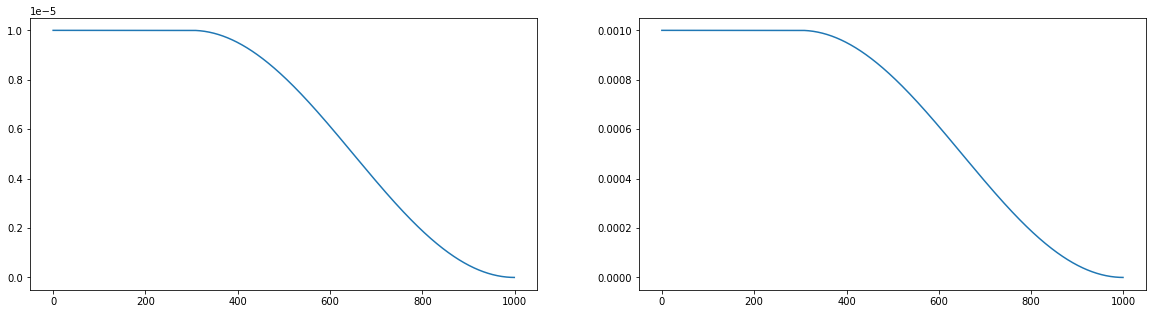

In [29]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(20, 5))
ax0.plot(lrs0)
ax1.plot(lrs1)

In [30]:
rand_input = torch.randn((4, 255))
rand_model = torch.nn.Linear(in_features=255, out_features=1, bias=False)

rand_preds = rand_model(rand_input)
rand_output= torch.ones_like(rand_preds)
loss = torch.nn.functional.binary_cross_entropy_with_logits(rand_preds, rand_output)
loss.backward()

opt = ranger(params(rand_model), decouple_wd=True)
opt.step()

In [31]:
rand_input = torch.randn((4, 255))
rand_model = torch.nn.Linear(in_features=255, out_features=1, bias=False)

rand_preds = rand_model(rand_input)
rand_output= torch.ones_like(rand_preds)
loss = torch.nn.functional.binary_cross_entropy_with_logits(rand_preds, rand_output)

opt = ranger(params(rand_model), decouple_wd=False)
opt.step()

In [33]:
#hide
from nbdev.export import *
notebook2script()

Converted 00_core.ipynb.
Converted 00a_lightning.core.ipynb.
Converted 00b_fastai.core.ipynb.
Converted 01_mixmethods.ipynb.
Converted 02_layers.ipynb.
Converted 02a_networks.ipynb.
Converted 03_optimizers.ipynb.
Converted index.ipynb.
